In [1]:
%%capture
!pip install datasets=="2.14.6" transformers=="4.35.0" accelerate=="0.24.1"
!pip install evaluate

In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForQuestionAnswering
from transformers import Trainer, TrainingArguments, pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

Загрузим датасет:

In [3]:
%%capture
dataset = load_dataset('sberquad')

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 45328
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5036
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 23936
    })
})

In [5]:
print("Context: ", dataset["train"][0]["context"])
print("Question: ", dataset["train"][0]["question"])
print("Answer: ", dataset["train"][0]["answers"])

Context:  В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.
Question:  чем представлены органические остатки?
Answer:  {'text': ['известковыми выделениями сине-зелёных водорослей'], 'answer_start': [109]}


In [6]:
print("Context: ", dataset["validation"][0]["context"])
print("Question: ", dataset["validation"][0]["question"])
print("Answer: ", dataset["validation"][0]["answers"])

Context:  Первые упоминания о строении человеческого тела встречаются в Древнем Египте. В XXVII веке до н. э. египетский врач Имхотеп описал некоторые органы и их функции, в частности головной мозг, деятельность сердца, распространение крови по сосудам. В древнекитайской книге Нейцзин (XI—VII вв. до н. э.) упоминаются сердце, печень, лёгкие и другие органы тела человека. В индийской книге Аюрведа ( Знание жизни , IX-III вв. до н. э.) содержится большой объём анатомических данных о мышцах, нервах, типах телосложения и темперамента, головном и спинном мозге.
Question:  Где встречаются первые упоминания о строении человеческого тела?
Answer:  {'text': ['в Древнем Египте'], 'answer_start': [60]}


In [7]:
train_dataset = dataset['train'].select(range(5000))
test_dataset = dataset['validation'].select(range(500))

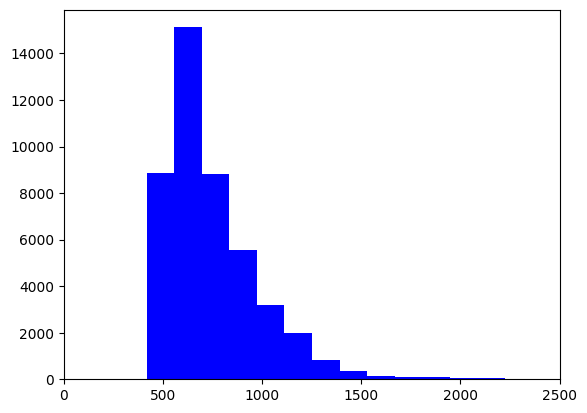

In [8]:
plt.hist([len(x) for x in dataset["train"]["context"]], color = 'blue', bins = 50);
plt.xlim(0, 2500);

Посмотрим, есть ли строки, в которых дано больше одного ответа:

In [9]:
dataset["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Filter:   0%|          | 0/45328 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

In [10]:
checkpoint = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [11]:
tokenizer.is_fast

True

In [12]:
context = dataset["train"][10]["context"]
question = dataset["train"][10]["question"]

inputs = tokenizer(
    question,
    context,
)

tokenizer.decode(inputs["input_ids"])

'[CLS] В каком году истекает договор аренды Байконура [SEP] Город Байконур и космодром Байконур вместе образуют комплекс Байконур, арендованный Россией у Казахстана на период до 2050 года. Эксплуатация космодрома стоит около 9 млрд рублей в год ( стоимость аренды комплекса Байконур составляет 115 млн долларов — около 7, 4 млрд рублей в год ; ещё около 1, 5 млрд рублей в год Россия тратит на поддержание объектов космодрома ), что составляет 4, 2 % от общего бюджета Роскосмоса на 2012 год. Кроме того, из федерального бюджета России в бюджет города Байконура ежегодно осуществляется безвозмездное поступление в размере 1, 16 млрд рублей ( по состоянию на 2012 год ). В общей сложности космодром и город обходятся бюджету России в 10, 16 млрд рублей в год. [SEP]'

In [13]:
dataset["train"][10]["answers"]

{'text': ['2050'], 'answer_start': [119]}

In [14]:
max_length = 384
stride = 128

def preprocess_training_examples(examples):
    inputs = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [15]:
train_data = train_dataset.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=train_dataset.column_names,
)
len(train_data), len(dataset['train'])

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

(5015, 45328)

In [16]:
test_data = test_dataset.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=test_dataset.column_names,
)
len(test_data), len(dataset['test'])

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

(502, 23936)

In [17]:
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=100,
    save_steps=100,
    do_train=True,
    do_eval=True,
    load_best_model_at_end=True,
    seed=24)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.105600,1.830070
2,1.637300,1.757349


TrainOutput(global_step=1254, training_loss=2.1329625812633948, metrics={'train_runtime': 846.0296, 'train_samples_per_second': 11.855, 'train_steps_per_second': 1.482, 'total_flos': 1965604852546560.0, 'train_loss': 2.1329625812633948, 'epoch': 2.0})

In [20]:
dataset["validation"][5]['answers']

{'text': ['оральные и назальные'], 'answer_start': [735]}

In [21]:
metric = load_metric("squad")

def compute_metrics(p):
    predictions, labels = p
    start_preds, end_preds = predictions
    start_labels, end_labels = labels

    start_preds = np.argmax(start_preds, axis=1)
    end_preds = np.argmax(end_preds, axis=1)

    formatted_predictions = []
    for idx, (start, end) in enumerate(zip(start_preds, end_preds)):
        pred_text = tokenizer.decode(test_data[idx]['input_ids'][start:end+1],
                                     skip_special_tokens=True)
        formatted_predictions.append({"id": idx, "prediction_text": pred_text})

    references = [{"id": idx, "answers": dataset["validation"][idx]['answers']} for idx in range(len(test_data))]

    return metric.compute(predictions=formatted_predictions, references=references)

trainer_base = Trainer(
    model=AutoModelForQuestionAnswering.from_pretrained(checkpoint),
    compute_metrics=compute_metrics,
    eval_dataset=test_data,
)

base_metrics = trainer_base.evaluate()
trainer.compute_metrics = compute_metrics
fine_tuned_metrics = trainer.evaluate()

results_df = pd.DataFrame({
    "Metric": ["Loss", "Exact Match", "F1 Score"],
    "Base Model": [base_metrics['eval_loss'], base_metrics['eval_exact_match'], base_metrics['eval_f1']],
    "Fine-tuned Model": [fine_tuned_metrics['eval_loss'], fine_tuned_metrics['eval_exact_match'], fine_tuned_metrics['eval_f1']],
})


display(results_df)

<ipython-input-21-8c21c3d5941a>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad")


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Metric,Base Model,Fine-tuned Model
0,Loss,5.940046,1.757349
1,Exact Match,0.000000,1.992032
2,F1 Score,0.829136,4.018137
